# [Contents Based Filtering](https://hipster4020.tistory.com/113)
사용자가 특정 아이템을 선호하는 경우 그 아이템과 비슷한 컨텐츠를 가진 다른 아이템을 추천해주는 방식이다.   
컨텐츠 자체를 분석하는 방식이기 때문에 초기의 사용자 행동 데이터가 적도라도 추천할 수 있는 장점이 있다.

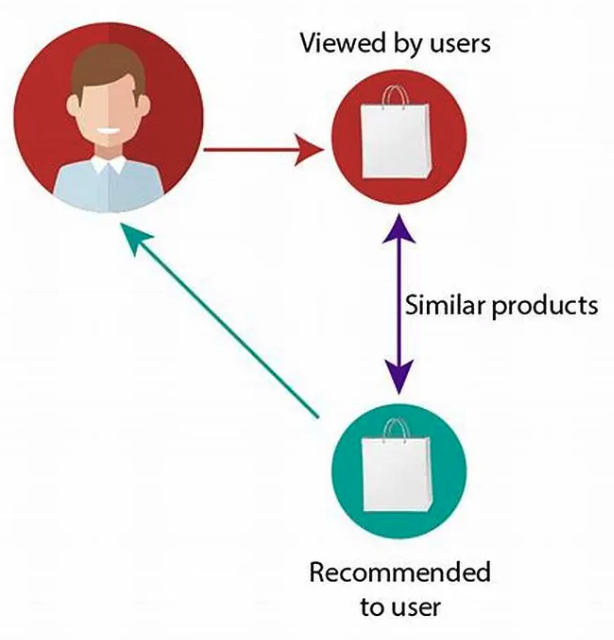

In [ ]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# [Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv)



In [ ]:
DATA_PATH = "/content/data/MyDrive/lecture/6. deep learning/7-4. RS_Pytorch/data/Movie/"

movies = pd.read_csv(DATA_PATH+"tmdb_5000_movies.csv")

print(f'{movies.shape}')
movies.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


## 결측치
사용할 컬럼들('id', 'title', 'genres', 'vote_average', 'vote_count')에는 결측치가 없으므로 따로 작업을 하지 않음

In [ ]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

## 필요 컬럼 추출

In [ ]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count']]
movies_df.head()

,id,title,genres,vote_average,vote_count
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",6.9,4500
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.3,4466
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7.6,9106
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.1,2124


## genres 가공
literal_eval()를 이용하여 각 문자열을 문자열이 의미하는 `list[dict, dict]` 형태의 객체로 변경 

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(literal_eval)

apply lambda를 이용하여 name 데이터를 추출 

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])

In [ ]:
movies_df.head()

,id,title,genres,vote_average,vote_count
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124


# 장르 컨텐츠 유사도 측정 
장르별 유사도 측정 방법은 genres를 문자열로 변경한 뒤 CountVectorizer로 피처 벡터화한 형렬 데이터 값을 코사인 유사도로 비교합니다.

## 유사도 측정 순서

1. 리스트 객체로 구성된 genres 컬럼을 apply(lambda x: (' ').join(x))를 이용해 공백문자로 구분되는 문자열로 변환하여 별도의 컬럼인 genres_literal 컬럼으로 저장
2. CountVectorizer를 이용하여 Count 기반으로 피처 벡터 행렬로 변환
3. 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교하여 유사도가 높은 영화 중 평점이 높은 순으로 추천 

피처 벡터 행렬을 코사인 유사도는 사이킷런의 cosine_similarity()를 이용하여 측정할 수 있습니다. 아래 그림은 코사인 유사도를 행렬 형태로 변환되는 것을 표현한 것이다.

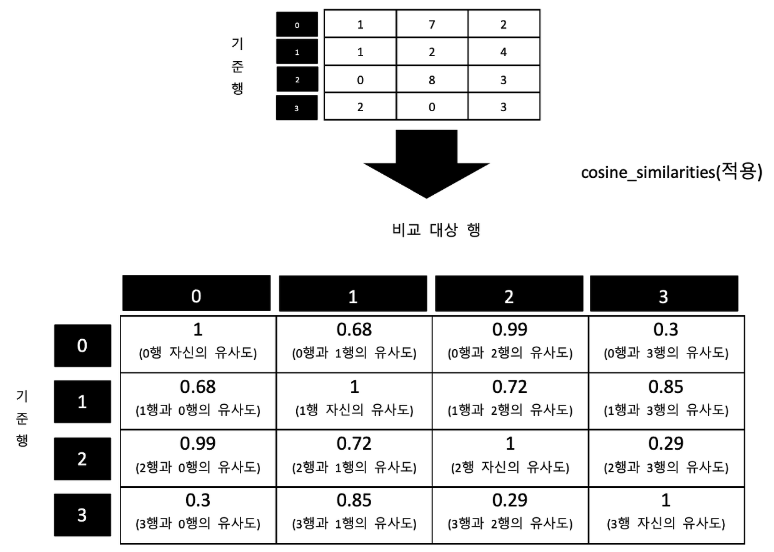

## CountVectorizer 
단어들의 카운트(출현 빈도)로 여러 문서들을 벡터화한다.  

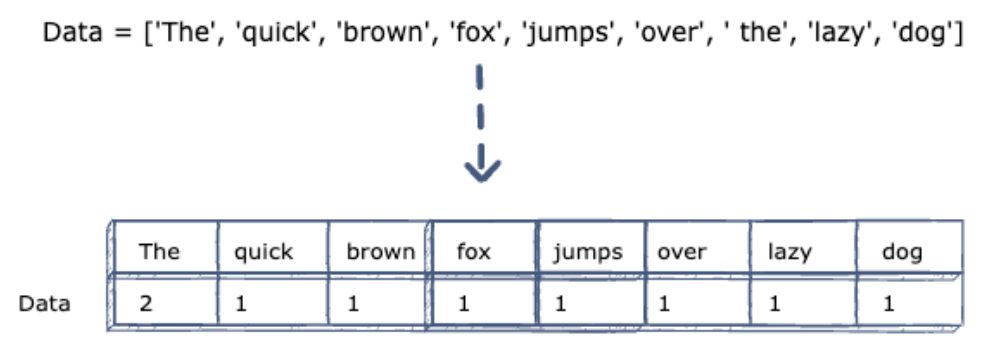

In [ ]:
# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' ').join(x))

In [ ]:
movies_df.head()

,id,title,genres,vote_average,vote_count,genres_literal
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,Action Adventure Fantasy Science Fiction
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,Adventure Fantasy Action
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,Action Adventure Crime
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106,Action Crime Drama Thriller
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124,Action Adventure Science Fiction


movies_df의 genres 컬럼을 문자열 변환하고 피처 벡터화한 행렬 genre_mat를 cosine_similarities()로 계산된 genre_sim 객체는 movies_df의 행렬 장르 유사도 값을 가지고 있습니다.

In [ ]:
# min_df는 너무 드물게로 나타나는 용어를 제거하는 데 사용(min_df = 0.01은 문서의 1% 미만에 나타나는 용어를 무시)
# ngram_range는 n-그램 범위 
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2)) 
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


In [ ]:
count_vect.vocabulary_

{'action': 0,
 'adventure': 16,
 'fantasy': 124,
 'science': 232,
 'fiction': 138,
 'action adventure': 1,
 'adventure fantasy': 24,
 'fantasy science': 135,
 'science fiction': 233,
 'fantasy action': 125,
 'crime': 64,
 'adventure crime': 20,
 'drama': 90,
 'thriller': 234,
 'action crime': 4,
 'crime drama': 68,
 'drama thriller': 106,
 'adventure science': 29,
 'animation': 33,
 'family': 109,
 'animation family': 38,
 'fantasy family': 130,
 'action science': 12,
 'adventure action': 17,
 'action thriller': 13,
 'thriller crime': 238,
 'western': 265,
 'adventure western': 32,
 'adventure family': 23,
 'family fantasy': 115,
 'fiction action': 139,
 'action fantasy': 7,
 'comedy': 44,
 'action comedy': 3,
 'comedy science': 59,
 'adventure drama': 22,
 'drama action': 91,
 'romance': 214,
 'drama romance': 104,
 'romance thriller': 228,
 'thriller action': 235,
 'fiction thriller': 150,
 'adventure thriller': 30,
 'fantasy adventure': 126,
 'family adventure': 111,
 'adventure com

In [ ]:
genre_mat.toarray()

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)

(4803, 4803)


In [ ]:
genre_sim[:1]

array([[1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
genre_sim

array([[1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
        0.        ],
       [0.59628479, 1.        , 0.4       , ..., 0.        , 0.        ,
        0.        ],
       [0.4472136 , 0.4       , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

코사인 유사도가 측정된 genre_sim 객체를 Numpy의 argsort()를 통해 유사도가 높은 순 정렬합니다.    
또한, 각 레코드에서 맨 뒤에 있는 인덱스 값을 비교 행 위치로 뒤집어 줍니다.   

결과 값을 보자면 첫 번째(0번) 레코드의 경우 자기 자신 0번을 제외하면 3494번 레코드가 가장 유사도가 높고 그 다음이 813번 레코드 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻입니다.

In [ ]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]

In [ ]:
genre_sim_sorted_ind.shape 

(4803, 4803)

In [ ]:
genre_sim_sorted_ind[:3]

array([[   0, 3494,  813, ..., 3038, 3037, 2401],
       [ 262,    1,  129, ..., 3069, 3067, 2401],
       [   2, 1740, 1542, ..., 3000, 2999, 2401]])

# 장르 컨텐츠 필터링을 이용한 영화 추천

데이터 프레임을 확인해보면 쇼생크 탈출(The Shawshank Redemption), 대부(The Godfather)와 같이 평가 수도 많고 평점이 높은 유명한 영화도 있으나 평가 수가 1개나 2개인 데이터의 평점이 상위권에 있는 것을 볼 수 있습니다.  

이러한 데이터를 실제로 추천하면 왜곡된 추천이므로 유명한 영화 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 방식을 사용합니다.  


Weighted Rating = (v / (v +m)) * R + (m / (v+m)) * C

- v: 영화에 평가를 매긴 횟수
- m: 평점을 부여하기 위한 최소 평가 수 
- R: 영화의 평균 평점
- C: 전체 영화의 평균 평점 


In [ ]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


In [ ]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile) # 평점을 부여하기 위한 최소 평가 수 
C = movies_df['vote_average'].mean() # 전체 영화의 평균 평점 

In [ ]:
m 

370.1999999999998

In [ ]:
C 

6.092171559442016

In [ ]:
def weighted_vote_average(record):
  v = record['vote_count'] # 영화에 평가를 매긴 횟수 
  R = record['vote_average'] # 영화의 평균 평점 

  return ( (v/(v+m)) * R) + ( (m/(m+v)) * C) # 가중 평점 계산 식  

In [ ]:
movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [ ]:
movies_df.head()

,id,title,genres,vote_average,vote_count,genres_literal,weighted_vote
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,Action Adventure Fantasy Science Fiction,7.166301
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,Adventure Fantasy Action,6.838594
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,Action Adventure Crime,6.284091
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106,Action Crime Drama Thriller,7.541095
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124,Action Adventure Science Fiction,6.098838


새롭게 부여된 가중 평점(weighted_vote) 컬럼을 기준으로 정렬한 결과이다.  
이제 가중 평점을 토대로 인자 값 장르 코사인 유사도 인덱스를 가지고 있는 객체, 추천 대상의 기준이 되는 아이템 이름(영화 제목), 추천할 영화 건수를 입력하면 추천 영화 정보를 가지는 DataFrame을 반환하는 함수를 만들 수 있다.

In [ ]:
movies_df[['title', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,weighted_vote,vote_count
1881,The Shawshank Redemption,8.396052,8205
3337,The Godfather,8.263591,5893
662,Fight Club,8.216455,9413
3232,Pulp Fiction,8.207102,8428
65,The Dark Knight,8.136930,12002
1818,Schindler's List,8.126069,4329
3865,Whiplash,8.123248,4254
809,Forrest Gump,8.105954,7927
2294,Spirited Away,8.105867,3840
2731,The Godfather: Part II,8.079586,3338


In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values 

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  # reshape(-1) 1차열 배열 반환 
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외 
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n 만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

노인을 위한 나라는 없다(No Country for Old Men)을 기준으로 추천해보자

In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'No Country for Old Men', 10)

In [ ]:
similar_movies[['title', 'vote_count', 'weighted_vote']]

,title,vote_count,weighted_vote
3234,Nightcrawler,3395,7.451748
1394,Donnie Brasco,1147,7.080887
867,The Godfather: Part III,1546,6.905293
1105,Sleepers,715,6.887967
1328,The Town,1468,6.817170
4226,Nine Queens,153,6.474621
1038,The Infiltrator,573,6.400681
2240,A Most Violent Year,546,6.335213
3789,Trust,307,6.322389
3091,Killer Joe,425,6.310138
